In [2]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from pclib.utils.customdataset import PreloadedDataset
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
class LogReg(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(LogReg, self).__init__()
        self.prelin = torch.nn.Linear(784, input_size, bias=False)
        self.linear = torch.nn.Linear(input_size, output_size)
        
    def forward(self, x):
        # x = pc(x).detach()
        with torch.no_grad():
            x = self.prelin(x)
        return self.linear(x)

# U1 = torch.nn.Linear(24, 784, bias=False)
# U1.to(device)


In [4]:
VAL_RATIO = 0.1
# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
# ])
transform = transforms.ToTensor()

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())
# shorten dataset
# length = 100
# dataset = torch.utils.data.Subset(dataset, range(length))
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, transforms.ToTensor(), device)
INPUT_SHAPE = 784
NUM_CLASSES = 10

  0%|          | 0/54000 [00:00<?, ?it/s]

In [5]:
BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
seed = 42
torch.manual_seed(seed)

INPUT_SHAPE = 256
model_name = f"mnist_linear_pre-lin{INPUT_SHAPE}"
LEARNING_RATE = 0.0001
model = LogReg(INPUT_SHAPE, NUM_CLASSES).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()
step = 0

In [7]:
def test(
    model,
    criterion,
    test_loader,
):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(-1, 784).to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = correct / len(test_loader.dataset)
    return test_loss, test_acc

def train(
    model,
    optimiser,
    criterion,
    train_loader,
    val_loader,
    num_epochs=10,
    device=device,
    model_name=model_name,
    step=step,
):
    writer = SummaryWriter(f"mnist/out/logs/{model_name}")
    train_losses = []
    val_losses = []
    val_accs = []

    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0

        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        for batch_idx, (data, target) in loop:
            data = data.view(-1, 784).to(device)
            optimiser.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            epoch_loss += loss.item()
            loss.backward()
            optimiser.step()
            step += 1
            if batch_idx == 0:

                torch.save(model.state_dict(), f"{model_name}.pth")
                val_loss, val_acc = test(model, criterion, val_loader)
                model.train()

            #  TQDM bar update
            if epoch > 0 and batch_idx > 0:
                loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
                loop.set_postfix(
                    train_loss = train_losses[-1],
                    val_loss = val_losses[-1], 
                    val_acc = val_accs[-1],
                )

        train_losses.append(epoch_loss / len(train_loader.dataset))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
            
        writer.add_scalar("Loss/train", train_losses[-1], step)
        writer.add_scalar("Loss/val", val_losses[-1], step)
        writer.add_scalar("Accuracy/val", val_accs[-1], step)
    return train_losses, val_losses, val_accs, step

In [8]:
NUM_EPOCHS = 5
train_losses, val_losses, val_accs, step = train(
    model,
    optimiser,
    criterion,
    train_loader,
    val_loader,
    num_epochs=NUM_EPOCHS,
    device=device,
    model_name=model_name,
    step=step,
)

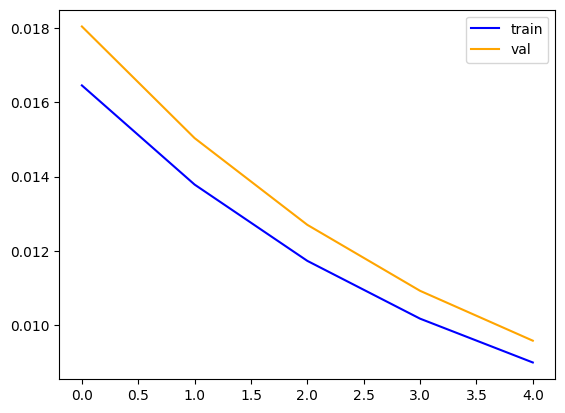

min val loss: 0.009579485694567362
min train loss: 0.008992450765989445


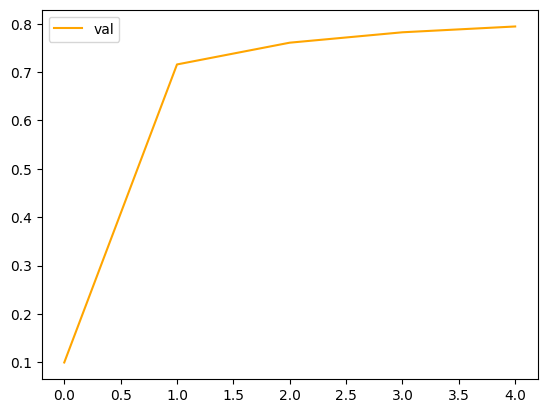

max val acc: 0.7943333333333333


In [9]:
# plot em all
import matplotlib.pyplot as plt
plt.plot(train_losses, label="train", color="blue")
plt.plot(val_losses, label="val", color="orange")
plt.legend()
plt.show()

# print mins
print("min val loss:", min(val_losses))
print("min train loss:", min(train_losses))

plt.plot(val_accs, label="val", color="orange")
plt.legend()
plt.show()

#print maxes
print("max val acc:", max(val_accs))